In [349]:
# Importing the required modules

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare, stats
from statsmodels.stats.weightstats import ztest

df = pd.read_csv("bike_sharing.csv")
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [350]:
# Checking if any null value requires attention
df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


## Column Profiling:
- **datetime**: datetime
- **season**: 
    - **1**: spring
    - **2**: summer
    - **3**: fall
    - **4**: winter
- **holiday**: whether day is a holiday or not
- **workingday**: if day is neither weekend nor holiday is 1, otherwise is 0.
- **weather**:
    - **1**: Clear, Few clouds, partly cloudy, partly cloudy
    - **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp**: temperature in Celsius
- **atemp**: feeling temperature in Celsius
- **humidity**: humidity
- **windspeed**: wind speed
- **casual**: count of casual users
- **registered**: count of registered users
- **count**: count of total rental bikes including both casual and registered

In [352]:
# Checking the datetime column values available
print("First entry:", sorted(df.datetime)[0])
print("Last entry:", sorted(df.datetime)[-1])

First entry: 2011-01-01 00:00:00
Last entry: 2012-12-19 23:00:00


In [353]:
df["datetime"] = pd.to_datetime(df["datetime"])
print(
    f"We have {df.shape[0]} non-null rows containing hourly rental count data available from:\n{df.loc[0,'datetime'].strftime('%B, %Y')} to {df.loc[df.shape[0]-1, 'datetime'].strftime('%B, %Y')}")

We have 10886 non-null rows containing hourly rental count data available from:
January, 2011 to December, 2012


In [354]:
# As per column description, we will change the data types for season weather, holiday, working day and datetime
df.season.replace({1: "spring", 2: "summer", 3: "fall",
                  4: "winter"}, inplace=True)
df.weather.replace({1: "clear", 2: "misty", 3: "light",
                  4: "heavy"}, inplace=True)
df.holiday = df.holiday.astype(bool)
df.workingday = df.workingday.astype(bool)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,spring,False,False,clear,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,spring,False,False,clear,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,spring,False,False,clear,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,spring,False,False,clear,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,spring,False,False,clear,9.84,14.395,75,0.0,0,1,1


Creating bins to capture the time of day:
- Early morning: 4am to 8am
- Late morning: 8am to 12pm
- Afternoon: 12pm to 4pm
- Evening : 4pm to 8pm
- Early night: 8pm to 12am
- Late night: 12am to 4am

In [355]:
# Capturing Month and Year for analysis
df['year'] = df["datetime"].dt.strftime("%Y")
df['month'] = df["datetime"].dt.strftime("%B")

# Capturing the hour of day for Creating bins to capture the time of day
df['hour_of_day'] = df["datetime"].dt.strftime("%H")
time_bins = ['00', '03', '07', '11', '15', '19', '23']
time_of_day_labels = ['late night', 'early morning',
                      'late morning', 'afternoon', 'evening', 'early night']
df['time_of_day'] = pd.cut(
    df['hour_of_day'], bins=time_bins, labels=time_of_day_labels)
df["time_of_day"].fillna("late night", inplace=True)
# df.drop(columns=['hour_of_day'], inplace=True)

df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour_of_day,time_of_day
0,2011-01-01 00:00:00,spring,False,False,clear,9.84,14.395,81,0.0,3,13,16,2011,January,00,late night
1,2011-01-01 01:00:00,spring,False,False,clear,9.02,13.635,80,0.0,8,32,40,2011,January,01,late night
2,2011-01-01 02:00:00,spring,False,False,clear,9.02,13.635,80,0.0,5,27,32,2011,January,02,late night
3,2011-01-01 03:00:00,spring,False,False,clear,9.84,14.395,75,0.0,3,10,13,2011,January,03,late night
4,2011-01-01 04:00:00,spring,False,False,clear,9.84,14.395,75,0.0,0,1,1,2011,January,04,early morning


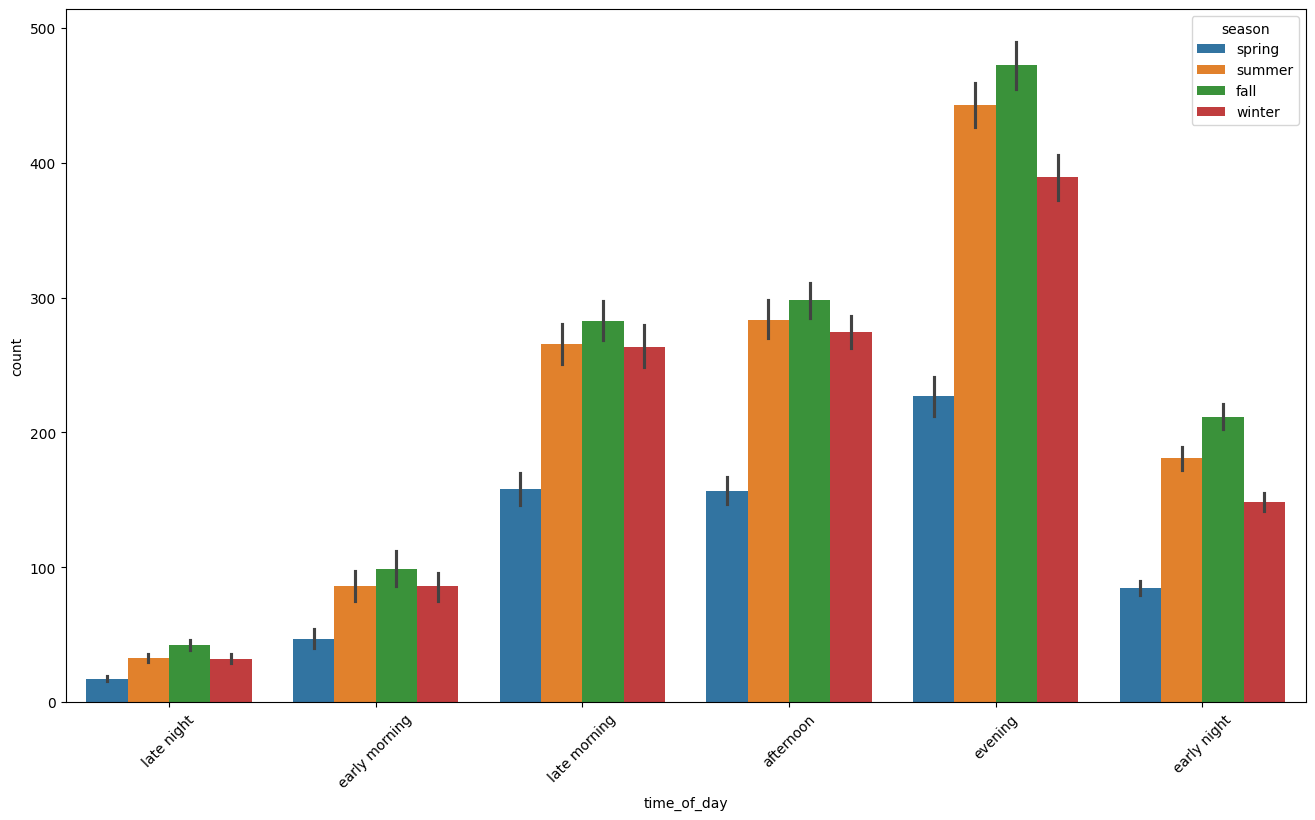

In [356]:
plt.figure(figsize=(16,9))
sns.barplot(data=df, x='time_of_day', y='count', hue='season')
plt.xticks(rotation=45)
plt.show()

For all seasons, evening time has the highest number of user counts observed with most users using the services during fall season.

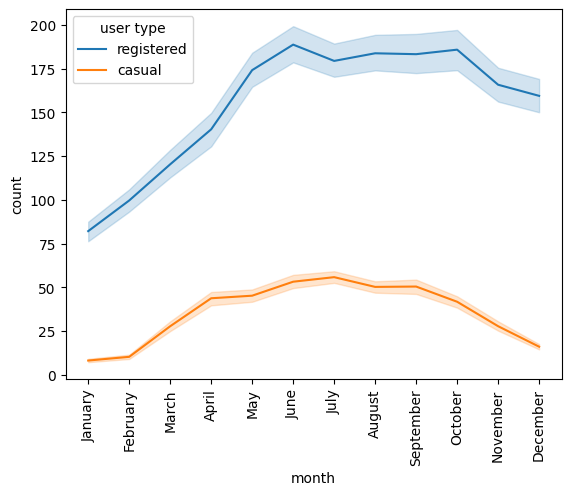

In [357]:
sns.lineplot(x='month', y='value', hue='variable',
             data=pd.melt(df[['registered', 'casual', 'month']], ['month']))
plt.xticks(rotation=90)
plt.ylabel("count")
plt.legend(title="user type")

From the above plot, we can infer that more registered and casual count in the middle of the year with lowest in the month of January

<Figure size 1600x1600 with 0 Axes>

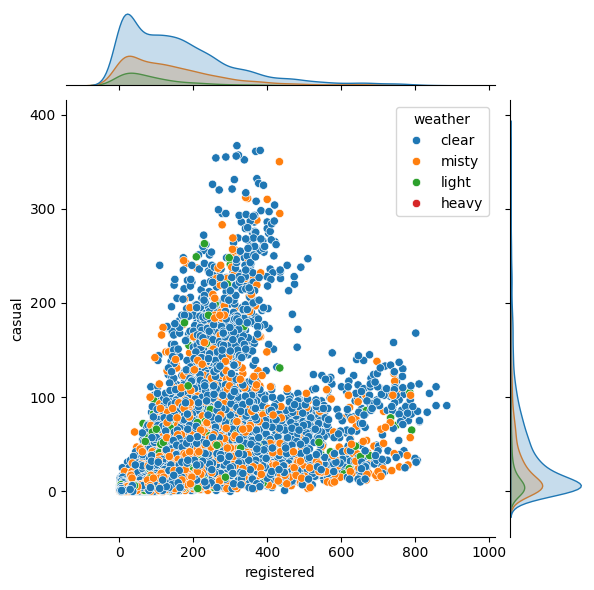

In [358]:
plt.figure(figsize=(16,16))
sns.jointplot(x='registered', y='casual', data=df, hue='weather')
plt.show()

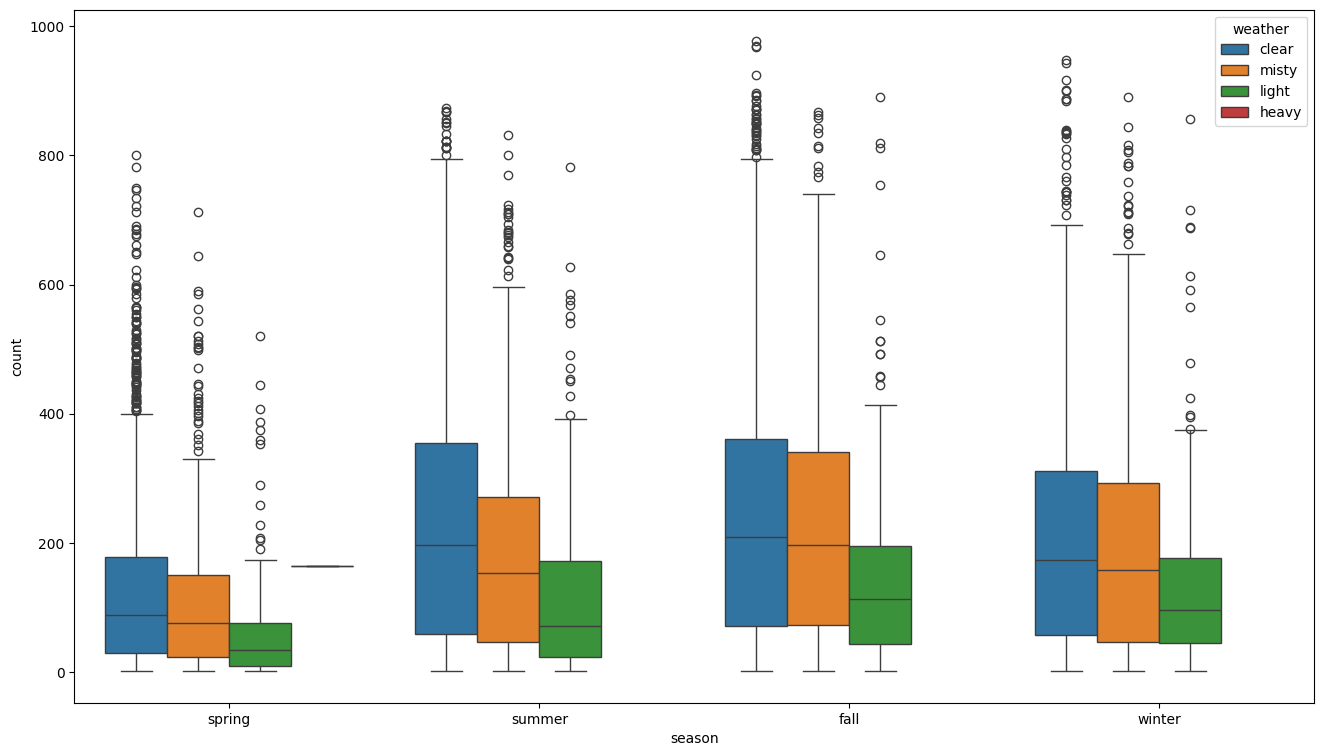

In [359]:
plt.figure(figsize=(16,9))
sns.boxplot(data = df, x="season", y="count", hue="weather")
plt.show()

We appear to have a lot of outliters which lie above the upper whisker across all seasons and weather throughout the year. So to check normality of distribution for count data available, we'll perform Shaprio-Wilk's test and plot QQ graph.

In [360]:
from scipy.stats import shapiro

# H0: Count Data is Gaussian
# Ha: Count Data is not Gaussian
test_stat, p_value = shapiro(
    df["count"].sample(5000))
print(p_value)

if p_value < 0.05:
    print("Reject H0")
    print("Count Data is not Gaussian")
else:
    print("Fail to reject H0")
    print("Count Data is Gaussian")

4.695317675518861e-53
Reject H0
Count Data is not Gaussian


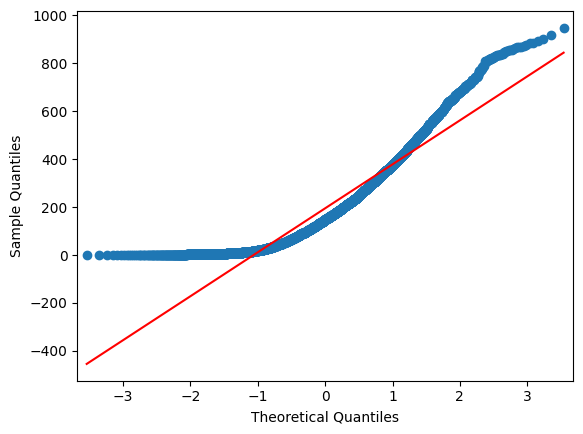

In [361]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df["count"].sample(5000), line="s")
plt.show()

After performing the Shapiro wilk test and plotting the QQ plot, we can infer that the count data distribution is NOT normally distributed.

### Workday's impact on Rental

In [362]:
workday_df = pd.melt(df[['count', 'workingday']], ['workingday'])
print("Total renatals observed during working day: ",
      workday_df[workday_df["workingday"]].value.sum())
print("Total renatals observed during non working day: ",
      workday_df[~workday_df["workingday"]].value.sum())

Total renatals observed during working day:  1430604
Total renatals observed during non working day:  654872


Clearly, the total rentals observed are more than twice during working days.

In [363]:
from scipy.stats import ttest_rel
# H0: Workday has an impact on rental
# Ha: Workday does not have an impact on rental

workday_data = workday_df[workday_df["workingday"]].value.sample(25).to_list()
non_workday_data = workday_df[~workday_df["workingday"]].value.sample(25).to_list()
_, p_value = ttest_rel(workday_data, non_workday_data)

print("p_value: ", p_value)
if p_value < 0.05:
    print("Reject Null Hypothesis.\nWith 95% confidence we can say that workday has no impact on bike rentals")
else:
    print("Failed to Reject Null Hypothesis.\nWorkday has an impact on rental")

p_value:  0.34259350502700614
Failed to Reject Null Hypothesis.
Workday has an impact on rental


### Season's impact on Cycle rentals

In [365]:
season_df = pd.melt(df[['count', 'season']], ['season'])
print("Total renatals observed during spring season: ",
      season_df[season_df["season"] == "spring"].value.sum())
print("Total renatals observed during summer season: ",
      season_df[season_df["season"] == "summer"].value.sum())
print("Total renatals observed during  fall  season: ",
      season_df[season_df["season"] == "fall"].value.sum())
print("Total renatals observed during winter season: ",
      season_df[season_df["season"] == "winter"].value.sum())

Total renatals observed during spring season:  312498
Total renatals observed during summer season:  588282
Total renatals observed during  fall  season:  640662
Total renatals observed during winter season:  544034


We will not be able to perform ANOVA test as one of the primary assumptions is that the data should be normally distributed. However, as per the QQ plot plotted earlier, we know that the count data is not follow Gaussian distribution. Hence, we will perform Kruskal Wallis test to check if No. of cycles rented is similar or different in different weather and seasonal conditions.

In [369]:
# Checking for similarities in bike rental count during different seasons

from scipy.stats import kruskal

spring_data = season_df[season_df["season"] == "spring"].value
summer_data = season_df[season_df["season"] == "summer"].value
fall_data = season_df[season_df["season"] == "fall"].value
winter_data = season_df[season_df["season"] == "winter"].value

stat, p_value = kruskal(spring_data, summer_data, fall_data, winter_data)

print("test statistic:", stat)
print("p_value:", p_value)

if p_value < 0.05:
    print("Reject H0")
    print("Atleast one group have different median")
else:
    print("Fail to reject H0")
    print("All groups have same median")

test statistic: 699.6668548181988
p_value: 2.4790083726086334e-151
Reject H0
Atleast one group have different median


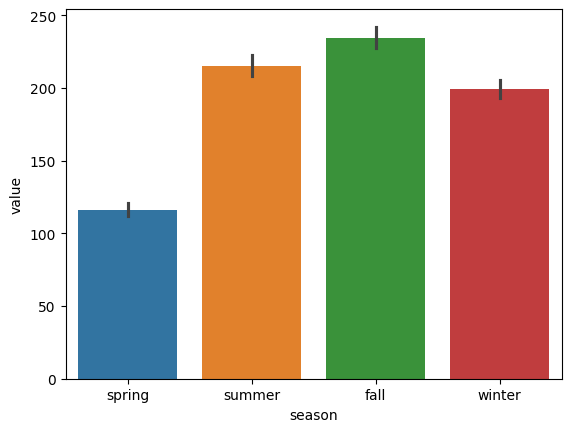

In [366]:
sns.barplot(data=season_df, x="season", y="value", hue="season")
plt.show()

Clearly, the total rentals observed are different across different seasons. Thus, confirming that season does have an impact on rentals.

### Weather's impact on Cycle rentals

In [367]:
weather_df = pd.melt(df[['count', 'weather']], ['weather'])
print("Total renatals observed during clear weather: ",
      weather_df[weather_df["weather"] == "clear"].value.sum())
print("Total renatals observed during misty weather: ",
      weather_df[weather_df["weather"] == "misty"].value.sum())
print("Total renatals observed during light rainfall: ",
      weather_df[weather_df["weather"] == "light"].value.sum())
print("Total renatals observed during heavy rainfall: ",
      weather_df[weather_df["weather"] == "heavy"].value.sum())

Total renatals observed during clear weather:  1476063
Total renatals observed during misty weather:  507160
Total renatals observed during light rainfall:  102089
Total renatals observed during heavy rainfall:  164


In [370]:
# Checking for similarities in bike rental count during different weather

from scipy.stats import kruskal

clear_data = weather_df[weather_df["weather"] == "clear"].value
misty_data = weather_df[weather_df["weather"] == "misty"].value
light_data = weather_df[weather_df["weather"] == "light"].value
heavy_data = weather_df[weather_df["weather"] == "heavy"].value

stat, p_value = kruskal(spring_data, summer_data, fall_data, winter_data)

print("test statistic:", stat)
print("p_value:", p_value)

if p_value < 0.05:
    print("Reject H0")
    print("Atleast one group have different median")
else:
    print("Fail to reject H0")
    print("All groups have same median")

test statistic: 699.6668548181988
p_value: 2.4790083726086334e-151
Reject H0
Atleast one group have different median


Clearly, the total rentals observed are different across different weathers. Thus, confirming that weather does have an impact on rentals

### Testing Weather's dependence on Season
Since we're comparing the correlation between 2 categorical variables, we'll perform Chi Square test

In [368]:
from scipy.stats import chi2_contingency
# H0: Weather and Season are independent
# Ha: Weather and Season are dependent

val = pd.crosstab(index=df["weather"], columns=df["season"]).values
chi_stat, p_value, df, expected_values = chi2_contingency(val)

print("p_value: ", p_value)
if p_value < 0.05:
    print("Reject Null Hypothesis.\nWith 95% confidence we can say that Weather and Season are dependent")
else:
    print("Failed to Reject Null Hypothesis.\nWeather and Season are independent")

p_value:  1.5499250736864862e-07
Reject Null Hypothesis.
With 95% confidence we can say that Weather and Season are dependent
